In [28]:
import pickle
import matplotlib.pyplot as plt
import japanize_matplotlib
import pywt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from pathlib import Path

In [29]:
data_file_path = "../data/20250512/processed/ishii_task2_merged.pkl"

In [30]:
# pickleのEEGデータを読み込む
with open(data_file_path, 'rb') as f:
    data = pickle.load(f)

epochs_list = data['epochs_data']  # エポックデータ
labels = data['labels']  # ラベル
# drop_indices = data['drop_indices']  # 除外されたエポックのインデックス
fs = 500

In [31]:
epochs_list.shape

(168, 31, 2501)

In [32]:
labels

array([   3, 9999,    1, 9999,    1, 9999,    1, 9999,    2, 9999,    2,
       9999,    1, 9999,    3, 9999,    3, 9999,    2, 9999,    3, 9999,
          2, 9999,    3, 9999,    3, 9999,    1, 9999,    2, 9999,    1,
       9999,    3, 9999,    1, 9999,    2, 9999,    2, 9999,    3, 9999,
          1, 9999,    1, 9999,    1, 9999,    2, 9999,    2, 9999,    1,
       9999,    3, 9999,    3, 9999,    2, 9999,    3, 9999,    2, 9999,
          3, 9999,    3, 9999,    1, 9999,    2, 9999,    1, 9999,    3,
       9999,    1, 9999,    2, 9999,    2, 9999,    3, 9999,    1, 9999,
          1, 9999,    1, 9999,    2, 9999,    2, 9999,    1, 9999,    3,
       9999,    3, 9999,    2, 9999,    3, 9999,    2, 9999,    3, 9999,
          3, 9999,    1, 9999,    2, 9999,    1, 9999,    3, 9999,    1,
       9999,    2, 9999,    2, 9999,    3, 9999,    1, 9999,    1, 9999,
          1, 9999,    2, 9999,    2, 9999,    1, 9999,    3, 9999,    3,
       9999,    2, 9999,    3, 9999,    2, 9999,   

In [55]:
e0 = epochs_list[0, :, :]
e0c0 = epochs_list[0, 2, :]
e0c0

array([-1.54672657e-06,  1.07371657e-06,  2.81107454e-06, ...,
        5.83295581e-06,  5.41007651e-06,  6.07592870e-06], shape=(2501,))

In [34]:
# e0c0をwavelet変換する
scales = np.arange(1, 128)
# Morlet waveletでCWT実行
coefficients, frequencies = pywt.cwt(e0c0, scales, 'cmor', 1/fs)

/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


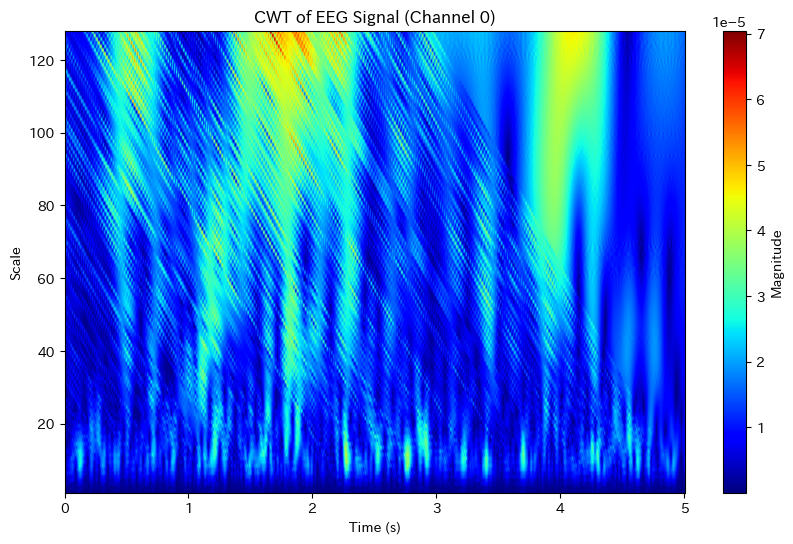

In [35]:
# Wavelet変換の結果をプロット
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(e0c0)/fs, 1, 128], cmap='jet', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('CWT of EEG Signal (Channel 0)')
plt.xlabel('Time (s)')
plt.ylabel('Scale')
plt.show()

In [36]:
def calc_spectrum(data, fs):
    coefficients, frequencies = pywt.cwt(e0c0, scales, 'cmor', 1/fs)
    power = np.abs(coefficients) ** 2

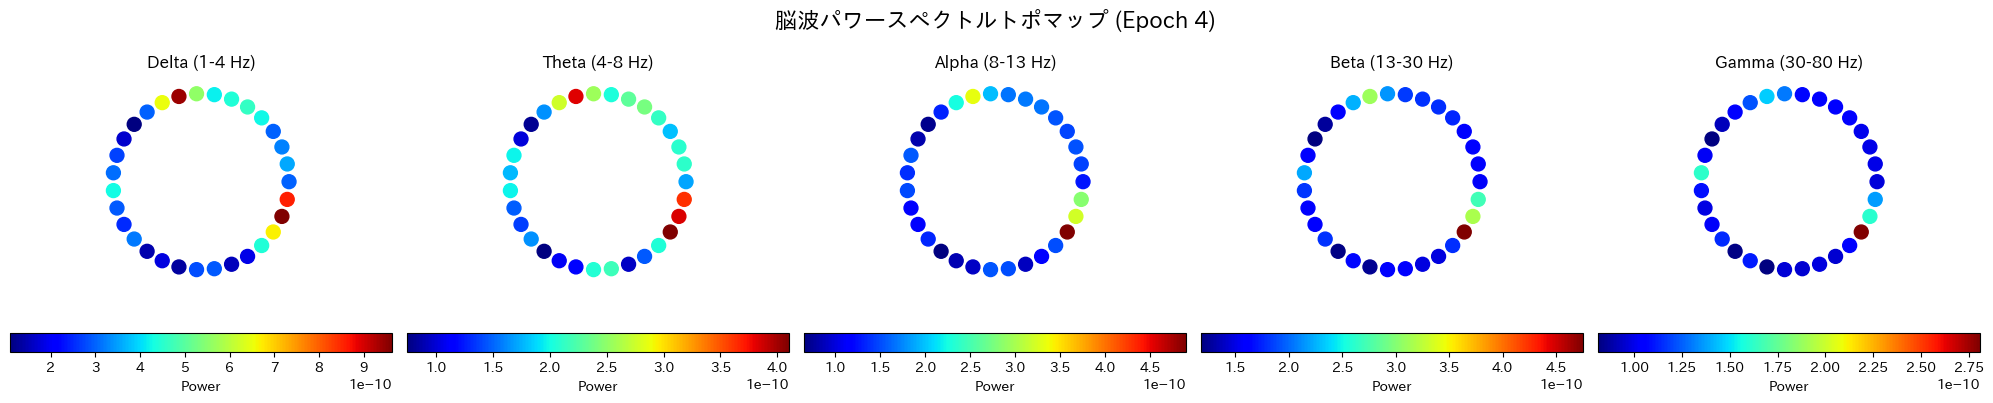

In [37]:
# 全チャンネルのwavelet変換の結果を格納するための配列
all_channel_power = np.zeros((31, len(scales)))

# 例としてepochs_list[5]を使用（先ほどのe0c0はepochs_list[5, 2, :]だった）
epoch_idx = 4

# 各チャネルに対してwavelet変換を実行
for ch in range(epochs_list.shape[1]):
    signal = epochs_list[epoch_idx, ch, :]
    coeffs, _ = pywt.cwt(signal, scales, 'cmor', 1/fs)
    # パワーを計算（複素数の絶対値の二乗）
    power = np.abs(coeffs)**2
    # 各スケールの平均パワーを計算
    all_channel_power[ch, :] = np.mean(power, axis=1)

# 可視化するスケール/周波数バンドを選択
# デルタ（1-4Hz）、シータ（4-8Hz）、アルファ（8-13Hz）、ベータ（13-30Hz）、ガンマ（30-100Hz）
freq_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 80)
}

# 各周波数帯のインデックスを取得
band_indices = {}
for band, (low, high) in freq_bands.items():
    # 周波数からスケールのインデックスを見つける
    low_idx = np.where(frequencies <= high)[0][0] if any(frequencies <= high) else 0
    high_idx = np.where(frequencies >= low)[0][-1] if any(frequencies >= low) else -1
    band_indices[band] = (low_idx, high_idx)

# トポマップを作成
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle(f'脳波パワースペクトルトポマップ (Epoch {epoch_idx})', fontsize=16)

# チャンネル位置の簡易的なマッピング（実際の電極位置に基づいて調整が必要）
# 本来はEEGキャップの電極配置に基づいて正確な位置情報が必要
# これは簡略化した例
n_channels = epochs_list.shape[1]
# 円状に電極を配置する簡易的なアプローチ
theta = np.linspace(0, 2*np.pi, n_channels, endpoint=False)
x = np.cos(theta)
y = np.sin(theta)
pos = np.vstack([x, y]).T

for i, (band, (low_idx, high_idx)) in enumerate(band_indices.items()):
    # 各バンドのパワーを計算
    band_power = np.mean(all_channel_power[:, low_idx:high_idx+1], axis=1)
    
    # トポマップのプロット
    im = axes[i].scatter(x, y, c=band_power, cmap='jet', s=100)
    axes[i].set_title(f'{band.capitalize()} ({freq_bands[band][0]}-{freq_bands[band][1]} Hz)')
    axes[i].set_xlim(-1.2, 1.2)
    axes[i].set_ylim(-1.2, 1.2)
    axes[i].set_aspect('equal')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], orientation='horizontal', label='Power')

plt.tight_layout()
plt.show()

In [38]:
epoch_idx = 4

# wavelet変換の、チャンネル
all_channel_power = np.zeros((31, len(scales)))
for ch in range(epochs_list.shape[1]):
    signal = epochs_list[epoch_idx, ch, :]
    coeffs, _ = pywt.cwt(signal, scales, 'cmor', 1/fs)
    power = np.abs(coeffs)**2
    all_channel_power[ch, :] = np.mean(power, axis=1)

all_channel_power



array([[1.63571518e-12, 3.50718566e-12, 1.27630762e-11, ...,
        3.98621675e-10, 4.03428087e-10, 4.09346184e-10],
       [1.67035718e-12, 3.60624512e-12, 1.31310832e-11, ...,
        4.92167897e-10, 4.97648880e-10, 5.03735539e-10],
       [1.67899041e-12, 3.65583884e-12, 1.32451097e-11, ...,
        4.29511272e-10, 4.34111895e-10, 4.39605826e-10],
       ...,
       [4.67821701e-12, 1.18326613e-11, 3.64684797e-11, ...,
        8.90076006e-10, 9.02669081e-10, 9.15950782e-10],
       [2.76997904e-12, 6.60381199e-12, 2.11506660e-11, ...,
        1.31913021e-09, 1.34279376e-09, 1.36900079e-09],
       [2.34423912e-12, 5.68145660e-12, 1.82807163e-11, ...,
        1.15035065e-09, 1.16889086e-09, 1.18965183e-09]], shape=(31, 127))

In [39]:
# labelsが9999のものを除外する
valid_indices = np.where(labels != 9999)[0]
epochs_list = epochs_list[valid_indices]
labels = labels[valid_indices]

In [40]:
epochs_list.shape

(84, 31, 2501)

In [41]:
labels

array([3, 1, 1, 1, 2, 2, 1, 3, 3, 2, 3, 2, 3, 3, 1, 2, 1, 3, 1, 2, 2, 3,
       1, 1, 1, 2, 2, 1, 3, 3, 2, 3, 2, 3, 3, 1, 2, 1, 3, 1, 2, 2, 3, 1,
       1, 1, 2, 2, 1, 3, 3, 2, 3, 2, 3, 3, 1, 2, 1, 3, 1, 2, 2, 3, 1, 1,
       1, 2, 2, 1, 3, 3, 2, 3, 2, 3, 3, 1, 2, 1, 3, 1, 2, 2])

In [42]:
# 1チャンネルのデータをWavelet変換してバンドパスパワーを計算
def calc_spectrum(data, band_count, fs):
    # サンプリングレートに応じてスケールを設定
    # 1-40Hzをカバーするスケール範囲を設定
    widths = np.arange(1, 128)
    
    # Morlet waveletでCWT実行
    coefficients, frequencies = pywt.cwt(data, widths, 'cmor', 1/fs)
    
    # パワーを計算（複素数の絶対値の二乗）
    power = np.abs(coefficients)**2
    
    # 1Hz-40Hzまでのband_count個のバンドパスパワーを計算
    band_lower = 1
    band_upper = 40
    band_powers = [None] * band_count
    
    for i in range(band_count):
        # 均等にバンドを分割
        band_min = band_lower + i * (band_upper - band_lower) / band_count
        band_max = band_lower + (i + 1) * (band_upper - band_lower) / band_count
        
        # 該当する周波数範囲のインデックスを取得
        band_indices = np.where((frequencies >= band_min) & (frequencies < band_max))[0]
        
        if len(band_indices) > 0:
            # 各バンドの平均パワーを計算
            band_powers[i] = np.mean(np.mean(power[band_indices, :], axis=1))
        else:
            # インデックスが見つからない場合は0を設定
            band_powers[i] = 0
    
    # band_powersの中にNoneがないことをassert
    assert all([v is not None for v in band_powers]), "Some band powers are None"
    
    return band_powers

In [43]:
# 全エポックのすべてのチャンネルに対してバンドパワーを計算
band_count = 20
all_epochs_band_powers = np.zeros((epochs_list.shape[0], epochs_list.shape[1], band_count))

for i in range(epochs_list.shape[0]):
    for j in range(epochs_list.shape[1]):
        epoch_data = epochs_list[i, j, :]
        print(f"Calculating band powers for epoch {i}, channel {j}")
        all_epochs_band_powers[i, j, :] = calc_spectrum(epoch_data, band_count, fs)

print(f"Calculated band powers for {epochs_list.shape[0]} epochs, {epochs_list.shape[1]} channels, {band_count} frequency bands")

Calculating band powers for epoch 0, channel 0
Calculating band powers for epoch 0, channel 1
Calculating band powers for epoch 0, channel 2
Calculating band powers for epoch 0, channel 3
Calculating band powers for epoch 0, channel 4
Calculating band powers for epoch 0, channel 5
Calculating band powers for epoch 0, channel 6
Calculating band powers for epoch 0, channel 7
Calculating band powers for epoch 0, channel 8
Calculating band powers for epoch 0, channel 9
Calculating band powers for epoch 0, channel 10
Calculating band powers for epoch 0, channel 11
Calculating band powers for epoch 0, channel 12
Calculating band powers for epoch 0, channel 13
Calculating band powers for epoch 0, channel 14
Calculating band powers for epoch 0, channel 15
Calculating band powers for epoch 0, channel 16
Calculating band powers for epoch 0, channel 17
Calculating band powers for epoch 0, channel 18
Calculating band powers for epoch 0, channel 19
Calculating band powers for epoch 0, channel 20
Ca

In [44]:
all_epochs_band_powers.shape

(84, 31, 20)

In [45]:
# pickleで保存
output_file_name= Path(data_file_path).stem + "_wavelet.pkl"
save_dir = Path(data_file_path).parent
output_file_path = save_dir / output_file_name
with open(output_file_path, 'wb') as f:
    pickle.dump({
        'band_powers': all_epochs_band_powers,
        'labels': labels
    }, f)
print(f"Saved band powers to {output_file_path}")

Saved band powers to ../data/20250512/processed/ishii_task2_merged_wavelet.pkl


In [46]:
# pickleで保存
output_file_name= Path(data_file_path).stem + "_wavelet.pkl"
save_dir = Path(data_file_path).parent
output_file_path = save_dir / output_file_name
with open(output_file_path, 'rb') as f:
    cached_data = pickle.load(f)

all_epochs_band_powers = cached_data['band_powers']
labels = cached_data['labels']

In [47]:
X = all_epochs_band_powers.reshape(all_epochs_band_powers.shape[0], -1)
print(f"特徴量のshape: {X.shape}")
print(f"ラベルのshape: {labels.shape}")

特徴量のshape: (84, 620)
ラベルのshape: (84,)


In [48]:
# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=labels)

In [49]:
# 特徴量のスケーリング
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# SVMモデルの作成と学習
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = svm.predict(X_test_scaled)

# 評価
print("分類レポート:")
print(classification_report(y_test, y_pred))# ラベルの分布を確認
unique_labels, counts = np.unique(labels, return_counts=True)
print("ラベルの分布:")
for label, count in zip(unique_labels, counts):
    print(f"ラベル {label}: {count}個")

分類レポート:
              precision    recall  f1-score   support

           1       0.30      0.88      0.45         8
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         9

    accuracy                           0.27        26
   macro avg       0.10      0.29      0.15        26
weighted avg       0.09      0.27      0.14        26

ラベルの分布:
ラベル 1: 28個
ラベル 2: 28個
ラベル 3: 28個


/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/neuron/Documents/mi-analyze/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

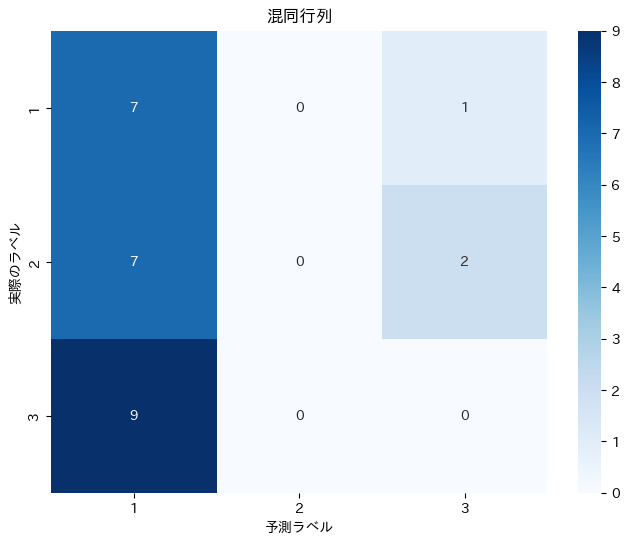

In [51]:
# 混同行列の表示
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=unique_labels, 
           yticklabels=unique_labels)
plt.xlabel('予測ラベル')
plt.ylabel('実際のラベル')
plt.title('混同行列')
plt.show()

クロスバリデーションスコア: [0.33333333 0.5        0.33333333 0.33333333 0.5        0.33333333
 0.16666667 0.33333333 0.         0.6       ]
平均精度: 0.3433 ± 0.1627


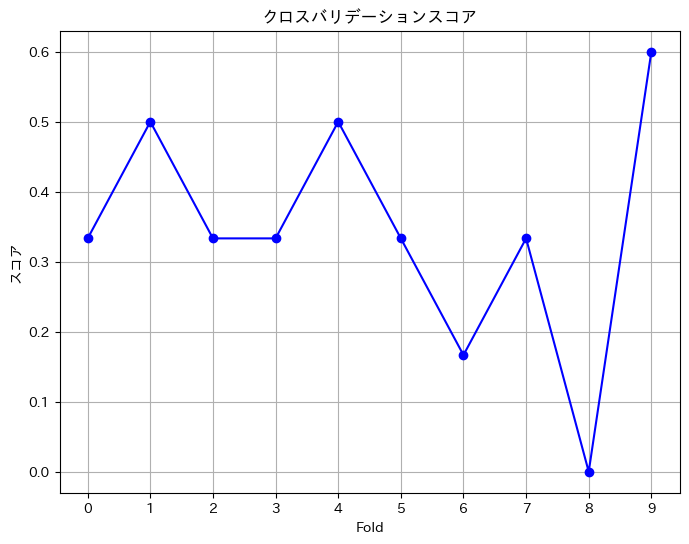

In [52]:
# クロスバリデーションで評価
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=10)
print(f"クロスバリデーションスコア: {cv_scores}")
print(f"平均精度: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
# クロスバリデーションの結果をプロット
plt.figure(figsize=(8, 6))
plt.plot(cv_scores, marker='o', linestyle='-', color='b')
plt.title('クロスバリデーションスコア')
plt.xlabel('Fold')
plt.ylabel('スコア')
plt.xticks(range(len(cv_scores)))
plt.grid()
plt.show()

In [53]:
# ハイパーパラメータチューニング
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"最適パラメータ: {grid_search.best_params_}")
print(f"最高スコア: {grid_search.best_score_:.4f}")

最適パラメータ: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
最高スコア: 0.4467


最適モデルのクロスバリデーションスコア: [0.16666667 0.66666667 0.5        0.16666667 0.5        0.5
 0.5        0.66666667 0.2        0.6       ]
最適モデルの平均精度: 0.4467 ± 0.1869
最適モデルの分類レポート:
              precision    recall  f1-score   support

           1       0.27      0.38      0.32         8
           2       0.23      0.33      0.27         9
           3       0.00      0.00      0.00         9

    accuracy                           0.23        26
   macro avg       0.17      0.24      0.20        26
weighted avg       0.16      0.23      0.19        26



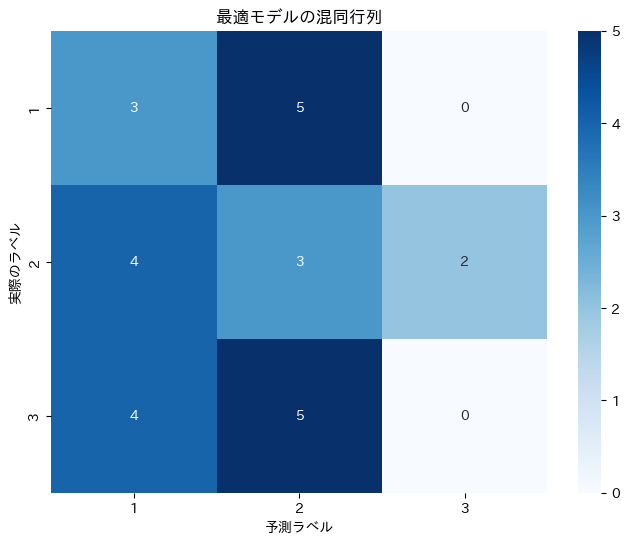

In [54]:
# 最適なモデルで評価
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)

# 最適なモデルのCVスコアを計算
best_cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=10)
print(f"最適モデルのクロスバリデーションスコア: {best_cv_scores}")
print(f"最適モデルの平均精度: {best_cv_scores.mean():.4f} ± {best_cv_scores.std():.4f}")

print("最適モデルの分類レポート:")
print(classification_report(y_test, y_pred_best))

# 混同行列の表示
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
           xticklabels=unique_labels, 
           yticklabels=unique_labels)
plt.xlabel('予測ラベル')
plt.ylabel('実際のラベル')
plt.title('最適モデルの混同行列')
plt.show()